In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_log_error as RMSLE
from sklearn.metrics import mean_squared_error as RMSE

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('../input/bri-data-hackathon-cr-optimization/train.csv')
train['periode'] = pd.to_datetime(train['periode'])
train.set_index(train['periode'], drop=True, inplace=True)

In [4]:
train.drop(['periode', 'cr_ketetapan_total_bkn_sum'], axis=1, inplace=True)

# Plot Kas Kantor and Kas E-Channel

Text(0.5, 1.0, 'kas_echannel')

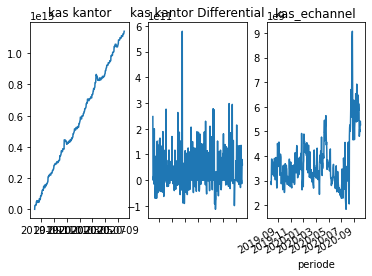

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(train.index, train['kas_kantor'])
ax1.set_title('kas kantor')

ax2.plot(train.index[1:], train['kas_kantor'].diff(1).dropna())
ax2.set_title('kas kantor Differential')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

ax3 = train['kas_echannel'].plot()
ax3.set_title('kas_echannel')

As you can see from the plot, there is certainly a trend in our Kas Kantor which means Kas Kantor is not stationary. Then I plot the diff(1) of Kas Kantor, and we can see that we have removed the trend. For mor convincing test, we will use Augmented Dickey Fuller test for the stationary test.

# Kas E-channel

Implement Augmented Dickey Fuller test for stationary test. Rule of thumb, if p-value is less than 0.5, then we stationary test is fullfiled. A simple explanation of Dickey Fuller test is written in [here](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [6]:
kas_echannel_adfuller = sm.tsa.stattools.adfuller(train['kas_echannel'])

print(f'ADF Statistic: {kas_echannel_adfuller[0]}')
print(f'p-value: {kas_echannel_adfuller[1]}')
print('Critical Values:')
for key, value in kas_echannel_adfuller[4].items():
	print(f'\t{key}: {value}')

ADF Statistic: -1.9838329126535938
p-value: 0.29370648146039885
Critical Values:
	1%: -3.4464005219454155
	5%: -2.868615280538588
	10%: -2.570538905413444


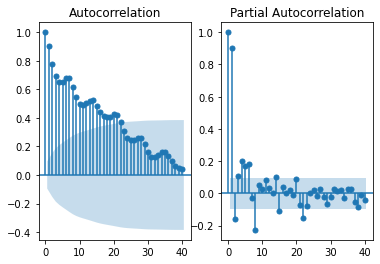

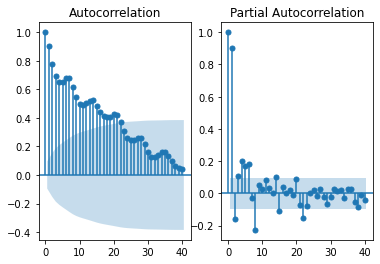

In [7]:
#Now plot the ACF and PACF graph
fig, (ax1, ax2) = plt.subplots(1,2)
smt.graphics.plot_acf(train['kas_echannel'], ax=ax1, lags=40)
smt.graphics.plot_pacf(train['kas_echannel'], ax=ax2, lags=40)

In [8]:
#From the plot, I can decide the critical value that I will use
p_val = [22, 15, 8, 6]
q_val = [22, 14, 7, 2]

In [9]:
train_set = train['kas_echannel'][:-30]
val_set = train['kas_echannel'][-30:]

In [10]:
model_echannel = []

for p in p_val:
    for q in q_val:
        mod = sm.tsa.arima.ARIMA(train_set, order=(p, 1, q))
        res = mod.fit()
        model_echannel.append(res) 
        print(f'p_val: {p}, q_val: {q}, aic: {res.aic}')

p_val: 22, q_val: 22, aic: 16780.913785348905
p_val: 22, q_val: 14, aic: 16768.754424499977
p_val: 22, q_val: 7, aic: 16759.899994550993
p_val: 22, q_val: 2, aic: 16759.67356221773
p_val: 15, q_val: 22, aic: 16774.056081929648
p_val: 15, q_val: 14, aic: 16763.763782347214
p_val: 15, q_val: 7, aic: 16753.31030968592
p_val: 15, q_val: 2, aic: 16757.112084838544
p_val: 8, q_val: 22, aic: 16762.747702224926
p_val: 8, q_val: 14, aic: 16751.68965462696
p_val: 8, q_val: 7, aic: 16749.645762498356
p_val: 8, q_val: 2, aic: 16752.523937540223
p_val: 6, q_val: 22, aic: 16762.863229490773
p_val: 6, q_val: 14, aic: 16753.975830355652
p_val: 6, q_val: 7, aic: 16757.496402559795
p_val: 6, q_val: 2, aic: 16755.85077772222


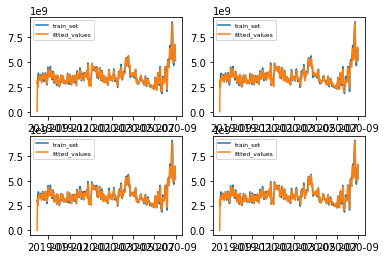

In [11]:
#Plot the training data and fitted value of the ARIMA Model
fig, ax = plt.subplots(2,2)

ax[0,0].plot(train_set)
ax[0,0].plot(model_echannel[2].fittedvalues)
ax[0,0].legend(['train_set', 'fitted_values'], prop={'size': 6})
 
ax[1,0].plot(train_set)
ax[1,0].plot(model_echannel[6].fittedvalues)
ax[1,0].legend(['train_set', 'fitted_values'], prop={'size': 6})

ax[0,1].plot(train_set)
ax[0,1].plot(model_echannel[7].fittedvalues)
ax[0,1].legend(['train_set', 'fitted_values'], prop={'size': 6})

ax[1,1].plot(train_set)
ax[1,1].plot(model_echannel[9].fittedvalues)
ax[1,1].legend(['train_set', 'fitted_values'], prop={'size': 6})

In [12]:
def change_index(val_set, pred_set):
    pred_set.index = val_set.index
    return pred_set

In [13]:
#See the RMSLE score for each ARIMA model
for i, mod in enumerate(model_echannel):
    y_pred = change_index(val_set, mod.forecast(30))
    score = RMSLE(val_set, y_pred)
    print(f'RMSLE-{i}: {score}, aic: {mod.aic}')

RMSLE-0: 0.01569716552324303, aic: 16780.913785348905
RMSLE-1: 0.028625162652800292, aic: 16768.754424499977
RMSLE-2: 0.008808956671715384, aic: 16759.899994550993
RMSLE-3: 0.00818850715266798, aic: 16759.67356221773
RMSLE-4: 0.011090177713215604, aic: 16774.056081929648
RMSLE-5: 0.08550794918638342, aic: 16763.763782347214
RMSLE-6: 0.07801806742220184, aic: 16753.31030968592
RMSLE-7: 0.007167811098656617, aic: 16757.112084838544
RMSLE-8: 0.008343648847392882, aic: 16762.747702224926
RMSLE-9: 0.009353254330020025, aic: 16751.68965462696
RMSLE-10: 0.08382493706809706, aic: 16749.645762498356
RMSLE-11: 0.012866201522315662, aic: 16752.523937540223
RMSLE-12: 0.010883860399701096, aic: 16762.863229490773
RMSLE-13: 0.007995819934655956, aic: 16753.975830355652
RMSLE-14: 0.012770231300351082, aic: 16757.496402559795
RMSLE-15: 0.014485724695914746, aic: 16755.85077772222


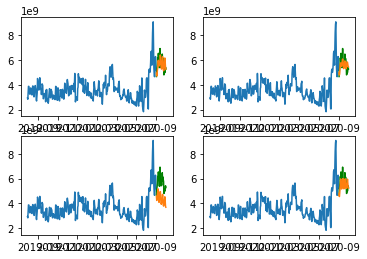

In [14]:
#Plot the forecast value and the validation set
fig, ax = plt.subplots(2,2)

ax[0,0].plot(train_set)
ax[0,0].plot(val_set, 'g')
y_pred = change_index(val_set, model_echannel[2].forecast(30))
ax[0,0].plot(y_pred)

ax[1,0].plot(train_set)
ax[1,0].plot(val_set, 'g')
y_pred = change_index(val_set, model_echannel[6].forecast(30))
ax[1,0].plot(y_pred)

ax[0,1].plot(train_set)
ax[0,1].plot(val_set, 'g')
y_pred = change_index(val_set, model_echannel[7].forecast(30))
ax[0,1].plot(y_pred)

ax[1,1].plot(train_set)
ax[1,1].plot(val_set, 'g')
y_pred = change_index(val_set, model_echannel[9].forecast(30))
ax[1,1].plot(y_pred)

From the plot, AIC, and the RMSLE score I choose the 2-nd ARIMA model that have p=22 and q=7

In [15]:
y_pred_echannel = model_echannel[2].forecast(61)

# Kas Kantor

In [16]:
kas_kantor_adfuller = sm.tsa.stattools.adfuller(train['kas_kantor'])

print(f'ADF Statistic: {kas_kantor_adfuller[0]}')
print(f'p-value: {kas_kantor_adfuller[1]}')
print('Critical Values:')
for key, value in kas_kantor_adfuller[4].items():
	print(f'\t{key}: {value}')

ADF Statistic: -0.14385169926916808
p-value: 0.9448917555389972
Critical Values:
	1%: -3.4465596717208813
	5%: -2.8686852499495843
	10%: -2.570576203741901


As predicted, we have p-value > 0.5 which means that it is not stationary. Now try to differentiate it by 1.

In [17]:
kas_kantor_adfuller = sm.tsa.stattools.adfuller(train['kas_kantor'].diff(1).dropna())

print(f'ADF Statistic: {kas_kantor_adfuller[0]}')
print(f'p-value: {kas_kantor_adfuller[1]}')
print('Critical Values:')
for key, value in kas_kantor_adfuller[4].items():
	print(f'\t{key}: {value}')

ADF Statistic: -5.984361857711548
p-value: 1.806909833788348e-07
Critical Values:
	1%: -3.446599953548936
	5%: -2.86870295908671
	10%: -2.570585643956714


Great! now we have p-value <0.5 which means it is now stationary. Now lets plot the ACF and PACF

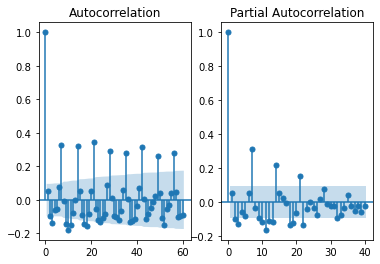

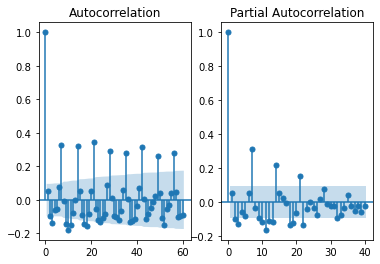

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
smt.graphics.plot_acf(train['kas_kantor'].diff(1).dropna(), ax=ax1, lags=60)
smt.graphics.plot_pacf(train['kas_kantor'].diff(1).dropna(), ax=ax2, lags=40)

In [19]:
p_val = [21, 14, 7]
q_val = [56, 42, 21]

In [20]:
train_set = train['kas_kantor'][:-30]
val_set = train['kas_kantor'][-30:]

In [21]:
model_kantor = [] 

for p in p_val:
    for q in q_val:
        mod = sm.tsa.arima.ARIMA(train_set.dropna(), order=(p, 1, q))
        res = mod.fit()
        model_kantor.append(res) 
        print(f'p_val: {p}, q_val: {q}, aic: {res.aic}')

p_val: 21, q_val: 56, aic: 20790.761216049348
p_val: 21, q_val: 42, aic: 20765.261494521175
p_val: 21, q_val: 21, aic: 20746.29046468738
p_val: 14, q_val: 56, aic: 20784.82786499474
p_val: 14, q_val: 42, aic: 20761.966270895347
p_val: 14, q_val: 21, aic: 20745.531784209477
p_val: 7, q_val: 56, aic: 20778.510844056203
p_val: 7, q_val: 42, aic: 20754.008551474843
p_val: 7, q_val: 21, aic: 20733.964040056064


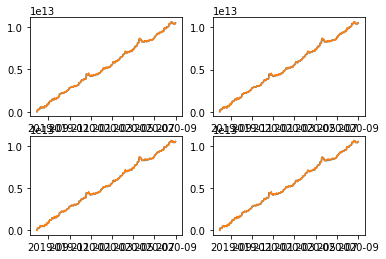

In [22]:
#Plot the training data and fitted value of the ARIMA Model

fig, ax = plt.subplots(2,2)

ax[0,0].plot(train_set)
ax[0,0].plot(model_kantor[0].fittedvalues)

ax[1,0].plot(train_set)
ax[1,0].plot(model_kantor[2].fittedvalues)

ax[0,1].plot(train_set)
ax[0,1].plot(model_kantor[5].fittedvalues)

ax[1,1].plot(train_set)
ax[1,1].plot(model_kantor[-1].fittedvalues)

In [23]:
#See the RMSLE score for each ARIMA model
for i, mod in enumerate(model_kantor):
    y_pred = mod.forecast(30)
    score = RMSLE(val_set, y_pred)
    print(f'RMSLE-{i}: {score}, aic: {mod.aic}')

RMSLE-0: 5.356613801226907e-05, aic: 20790.761216049348
RMSLE-1: 7.501472988504663e-05, aic: 20765.261494521175
RMSLE-2: 9.37829062491113e-05, aic: 20746.29046468738
RMSLE-3: 8.09573194973399e-05, aic: 20784.82786499474
RMSLE-4: 8.802159190010551e-05, aic: 20761.966270895347
RMSLE-5: 0.00014493393585179268, aic: 20745.531784209477
RMSLE-6: 5.700476307916947e-05, aic: 20778.510844056203
RMSLE-7: 9.661928801536959e-05, aic: 20754.008551474843
RMSLE-8: 5.6051158171911504e-05, aic: 20733.964040056064


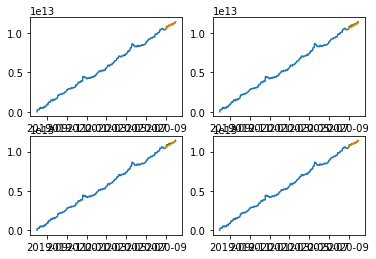

In [24]:
#Plot the forecast value and the validation set
fig, ax = plt.subplots(2,2)

ax[0,0].plot(train_set)
ax[0,0].plot(val_set, 'g')
y_pred = change_index(val_set, model_kantor[0].forecast(30))
ax[0,0].plot(y_pred)

ax[1,0].plot(train_set)
ax[1,0].plot(val_set, 'g')
y_pred = change_index(val_set, model_kantor[2].forecast(30))
ax[1,0].plot(y_pred)

ax[0,1].plot(train_set)
ax[0,1].plot(val_set, 'g')
y_pred = change_index(val_set, model_kantor[5].forecast(30))
ax[0,1].plot(y_pred)

ax[1,1].plot(train_set)
ax[1,1].plot(val_set, 'g')
y_pred = change_index(val_set, model_kantor[-1].forecast(30))
ax[1,1].plot(y_pred)

From the plot, AIC, and the RMSLE score I choose the last ARIMA model that have p=7 and q=21

In [25]:
y_pred_kantor = model_kantor[-1].forecast(61)

# Create Submission File

In [26]:
y_pred = pd.concat([y_pred_kantor[30:], y_pred_echannel[30:]], axis=0)
y_pred.reset_index(drop=True, inplace=True)
index = np.arange(len(y_pred))

y_pred = pd.concat([pd.Series(index), y_pred], axis=1)
y_pred.columns = ['index', 'value']

y_pred.to_csv('subm.csv', index=False, header=True)